In [29]:
import pandas as pd
import numpy as np

import empyrical as empy

import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [55]:
name_list = [
    'cycling_21D_start_1',
#     'vote_lookbackA_rollA_top20',
#     'vote_c3ema_rollA_lookback5_top1 (no future)',
#     'vote_c3ema_rollA_lookback3_top5 (no future)'
]

file_list = [
    'cycling_preds/preds.csv'
#     'output_others/20220428/pred_vote_lookbackA_rollA_top20.csv',
#     'output_others/20220428/pred_vote_c3ema_rollA_lookback5_top1_nofuture.csv',
#     'output_others/20220428/pred_vote_c3ema_rollA_lookback3_top5_nofuture.csv'
]

In [31]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


In [32]:
def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se


In [33]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se

In [34]:
def print_all_result(ret_df, sortby='sharpe_ratio', topn=None, strategy_list_sel=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd']
    empy_metric_tmp = empy_metric(ret_df).sort_values(sortby)
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        if topn is not None:
            if isinstance(topn, int):
                strategy_list_sel = strategy_list_sel[-topn:]
            else:
                strategy_list_sel = list(empy_metric_tmp.loc[topn:].index)

        if 'buy_and_hold' in strategy_list_sel:
            strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
        strategy_list_sel = ['buy_and_hold']+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
    return strategy_list_sel

In [35]:
"""
df = pd.read_csv('XAU_USD_from_api.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df.columns = df.columns.map(lambda x: x.lower())
df['adj_close'] = df.close

df
"""

"\ndf = pd.read_csv('XAU_USD_from_api.csv', index_col=0)\ndf.index = pd.to_datetime(df.index)\n\ndf.columns = df.columns.map(lambda x: x.lower())\ndf['adj_close'] = df.close\n\ndf\n"

In [36]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'

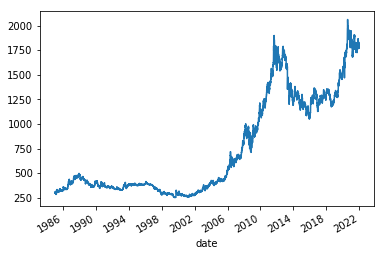

In [62]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price[start:end].plot()

In [63]:
true_ret = price.pct_change()
true_ret = true_ret[start:end]
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [64]:
true_up = (true_ret>=0)
true_up

date
1985-01-02    False
1985-01-03    False
1985-01-04     True
1985-01-07    False
1985-01-08     True
              ...  
2021-12-27     True
2021-12-28    False
2021-12-29    False
2021-12-30     True
2021-12-31     True
Name: adj_close, Length: 9612, dtype: bool

In [97]:
flag = pd.DataFrame()

## lookback N days count up/down trend

In [98]:
"""df = pd.read_csv(csv, index_col=0)
df.index = pd.to_datetime(df.index)
adj_close_pct_change = df.adj_close.pct_change()
df['adj_close_pct_change'] = adj_close_pct_change
roll = 21

df['count_up'] = (adj_close_pct_change>=0).shift().rolling(roll).sum()
df['count_all'] = (adj_close_pct_change>=0).shift().rolling(roll).count()
df['up_pct'] = df['count_up']/df['count_all']
df['lookback_pct'] = df.adj_close.pct_change(roll)
df['lookback_trend'] = (df['lookback_pct'] > 0)
df[['adj_close_pct_change', 'count_up', 'count_all', 'up_pct', 'lookback_pct', 'lookback_trend']]"""

"df = pd.read_csv(csv, index_col=0)\ndf.index = pd.to_datetime(df.index)\nadj_close_pct_change = df.adj_close.pct_change()\ndf['adj_close_pct_change'] = adj_close_pct_change\nroll = 21\n\ndf['count_up'] = (adj_close_pct_change>=0).shift().rolling(roll).sum()\ndf['count_all'] = (adj_close_pct_change>=0).shift().rolling(roll).count()\ndf['up_pct'] = df['count_up']/df['count_all']\ndf['lookback_pct'] = df.adj_close.pct_change(roll)\ndf['lookback_trend'] = (df['lookback_pct'] > 0)\ndf[['adj_close_pct_change', 'count_up', 'count_all', 'up_pct', 'lookback_pct', 'lookback_trend']]"

In [99]:
thresholds = [0.2, 0.3, 0.4]
lookback = [5, 10, 21]

df = pd.read_csv(csv, index_col=0)
df.index = pd.to_datetime(df.index)
adj_close_pct_change = df.adj_close.pct_change()
df['adj_close_pct_change'] = adj_close_pct_change

for l in lookback:
    df['count_up'] = (adj_close_pct_change>=0).shift().rolling(roll).sum()
    df['count_all'] = (adj_close_pct_change>=0).shift().rolling(roll).count()
    df['up_pct'] = df['count_up']/df['count_all']
    for t in thresholds:
        flag['roll{}_up_pct_exceed_{}'.format(l, t)] = (df['up_pct'] > t)

## avg price +/- 2 sd = normal trading range

In [100]:
df = pd.read_csv(csv, index_col=0)
df.index = pd.to_datetime(df.index)
df['adj_close_pct_change'] = df.adj_close.pct_change()
#df

In [101]:
base_list = ['adj_close', 'adj_close_pct_change']
roll_list = [5, 8, 16, 30]
k_std_list = [1, 1.5, 2]

# flag = pd.DataFrame()

for base in base_list:
    for roll in roll_list:
        
        name = '{}_roll{}'.format(base, roll)
        df[name+'_avg'] = df[base].shift().rolling(roll).mean()
        df[name+'_std'] = df[base].shift().rolling(roll).std()
        
        for k_std in k_std_list:
            
            name_strategy = name+'_exceed_{}std'.format(k_std)
            
            flag[name_strategy] = (df[base].shift()-df[name+'_avg']).abs() > k_std*df[name+'_std']

In [102]:
df

open     high      low  adj_close    close  \
date                                                        
1979-12-27   515.50   515.50   515.50     515.50   515.50   
1979-12-28   512.00   512.00   512.00     512.00   512.00   
1980-01-01   512.00   512.00   512.00     512.00   512.00   
1980-01-02   559.75   559.75   559.75     559.75   559.75   
1980-01-03   634.25   634.25   634.25     634.25   634.25   
...             ...      ...      ...        ...      ...   
2022-02-04  1804.80  1815.44  1790.94    1807.49  1807.49   
2022-02-07  1806.99  1824.06  1806.94    1820.31  1820.31   
2022-02-08  1820.59  1829.09  1815.06    1825.48  1825.48   
2022-02-09  1826.05  1836.35  1824.50    1832.43  1832.43   
2022-02-10  1832.60  1834.82  1831.56    1834.14  1834.14   

            adj_close_pct_change  adj_close_roll5_avg  adj_close_roll5_std  \
date                                                                         
1979-12-27                   NaN                  NaN                  NaN   
1979-12-28             -0.006790                  NaN                  NaN   
1980-01-01              0.000000                  NaN                  NaN   
1980-01-02              0.093262                  NaN                  NaN   
1980-01-03              0.133095                  NaN                  NaN   
...                          ...                  ...                  ...   
2022-02-04              0.001712             1799.810             6.220406   
2022-02-07              0.007093             1803.102             4.540966   
2022-02-08              0.002840             1807.870             7.432096   
2022-02-09              0.003807             1812.836             9.428973   
2022-02-10              0.000933             1818.022            11.884118   

            adj_close_roll8_avg  adj_close_roll8_std  ...  \
date                                                  ...   
1979-12-27                  NaN                  NaN  ...   
1979-12-28                  NaN                  NaN  ...   
1980-01-01                  NaN                  NaN  ...   
1980-01-02                  NaN                  NaN  ...   
1980-01-03                  NaN                  NaN  ...   
...                         ...                  ...  ...   
2022-02-04           1807.65500            18.081681  ...   
2022-02-07           1802.64625             8.413830  ...   
2022-02-08           1802.92000             9.004121  ...   
2022-02-09           1806.54125            11.529325  ...   
2022-02-10           1811.71625            12.794311  ...   

            adj_close_roll30_avg  adj_close_roll30_std  \
date                                                     
1979-12-27                   NaN                   NaN   
1979-12-28                   NaN                   NaN   
1980-01-01                   NaN                   NaN   
1980-01-02                   NaN                   NaN   
1980-01-03                   NaN                   NaN   
...                          ...                   ...   
2022-02-04           1813.904333             15.701661   
2022-02-07           1813.883667             15.709956   
2022-02-08           1814.197333             15.742237   
2022-02-09           1814.867667             15.781503   
2022-02-10           1815.826667             15.950194   

            adj_close_pct_change_roll5_avg  adj_close_pct_change_roll5_std  \
date                                                                         
1979-12-27                             NaN                             NaN   
1979-12-28                             NaN                             NaN   
1980-01-01                             NaN                             NaN   
1980-01-02                             NaN                             NaN   
1980-01-03                             NaN                             NaN   
...                                    ...                             ...   
2022-02-04                       

## RSI

In [103]:
rsi = pd.read_csv('./data/XAU_USD_rsi.csv', index_col=0)
rsi.index = pd.to_datetime(rsi.index)
rsi

RSI_5     RSI_10     RSI_14
date                                       
1980-01-04  97.216700        NaN        NaN
1980-01-07  96.975706        NaN        NaN
1980-01-08  74.742071        NaN        NaN
1980-01-09  72.323905        NaN        NaN
1980-01-10  68.514008        NaN        NaN
...               ...        ...        ...
2022-02-04  48.522834  47.338242  48.378813
2022-02-07  65.374713  55.211568  53.737289
2022-02-08  70.279327  58.023648  55.732924
2022-02-09  75.993407  61.622699  58.334891
2022-02-10  77.333670  62.501649  58.973856

[10916 rows x 3 columns]

In [104]:
lookbacks = [5, 10, 14]
thresholds = [40, 50, 60]
pair_thresholds = set(combinations(thresholds, 2))

for roll in lookbacks:
    for lower, upper in pair_thresholds:
        name_strategy = 'rsi_roll{}_out_{}-{}'.format(roll, lower, upper)
        base = 'RSI_{}'.format(roll)
        
        flag[name_strategy] = (rsi[base].shift() > upper) | (rsi[base].shift() < lower)

In [105]:
flag

roll5_up_pct_exceed_0.2  roll5_up_pct_exceed_0.3  \
date                                                           
1979-12-27                    False                    False   
1979-12-28                    False                    False   
1980-01-01                    False                    False   
1980-01-02                    False                    False   
1980-01-03                    False                    False   
...                             ...                      ...   
2022-02-04                     True                     True   
2022-02-07                     True                     True   
2022-02-08                     True                     True   
2022-02-09                     True                     True   
2022-02-10                     True                     True   

            roll5_up_pct_exceed_0.4  roll10_up_pct_exceed_0.2  \
date                                                            
1979-12-27                    False                     False   
1979-12-28                    False                     False   
1980-01-01                    False                     False   
1980-01-02                    False                     False   
1980-01-03                    False                     False   
...                             ...                       ...   
2022-02-04                     True                      True   
2022-02-07                     True                      True   
2022-02-08                     True                      True   
2022-02-09                     True                      True   
2022-02-10                     True                      True   

            roll10_up_pct_exceed_0.3  roll10_up_pct_exceed_0.4  \
date                                                             
1979-12-27                     False                     False   
1979-12-28                     False                     False   
1980-01-01                     False                     False   
1980-01-02                     False                     False   
1980-01-03                     False                     False   
...                              ...                       ...   
2022-02-04                      True                      True   
2022-02-07                      True                      True   
2022-02-08                      True                      True   
2022-02-09                      True                      True   
2022-02-10                      True                      True   

            roll21_up_pct_exceed_0.2  roll21_up_pct_exceed_0.3  \
date                                                             
1979-12-27                     False                     False   
1979-12-28                     False                     False   
1980-01-01                     False                     False   
1980-01-02                     False                     False   
1980-01-03                     False                     False   
...                              ...                       ...   
2022-02-04                      True                      True   
2022-02-07                      True                      True   
2022-02-08                      True                      True   
2022-02-09                      True                      True   
2022-02-10                      True                      True   

            roll21_up_pct_exceed_0.4  adj_close_roll5_exceed_1std  ...  \
date                                                               ...   
1979-12-27                     False                        False  ...   
1979-12-28                     False                        False  ...   
1980-01-01                     False                        False  ...   
1980-01-02                     False                        False  ...   
1980-01-03                     False                        False  ...   
...                              ...                          ...  ...   
2022-02-04             

In [106]:
def smooth_pred_by_flag_stop_lost(pred, flag):
    flag = flag.reindex(pred.index)
    
    p_smooth = pred.copy()
    i_prev = pred.index[0]
    for i in pred.index[1:]:
        if not flag[i]:
            p_smooth[i] = p_smooth[i_prev]
        i_prev = i
    
    return p_smooth

In [107]:
def smooth_pred_by_flag(pred, flag):
    flag = flag.reindex(pred.index)
    
    """
    p_smooth = pred.copy()
    i_prev = pred.index[0]
    for i in pred.index[1:]:
        if not flag[i]:
            p_smooth[i] = p_smooth[i_prev]
        i_prev = i
    """
    #p_smooth = pd.Series(np.nan, pred.index)
    #p_smooth.loc[flag.values] = p.loc[flag.values]
    
    
    p_smooth = pred*(flag.apply(lambda x: np.nan if not x else 1))
    
    p_smooth[pred.index[0]] = pred[pred.index[0]]
    p_smooth = p_smooth.ffill()
    
    return p_smooth

cycling_21D_start_1  \
date                              
1985-01-02                    1   
1985-01-03                    1   
1985-01-04                    1   
1985-01-07                    1   
1985-01-08                    1   
...                         ...   
2021-12-27                    0   
2021-12-28                    0   
2021-12-29                    0   
2021-12-30                    0   
2021-12-31                    0   

            cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2  \
date                                                             
1985-01-02                                                1.0    
1985-01-03                                                1.0    
1985-01-04                                                1.0    
1985-01-07                                                1.0    
1985-01-08                                                1.0    
...                                                       ...    
2021-12-27                                                0.0    
2021-12-28                                                0.0    
2021-12-29                                                0.0    
2021-12-30                                                0.0    
2021-12-31                                                0.0    

            cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3  \
date                                                             
1985-01-02                                                1.0    
1985-01-03                                                1.0    
1985-01-04                                                1.0    
1985-01-07                                                1.0    
1985-01-08                                                1.0    
...                                                       ...    
2021-12-27                                                0.0    
2021-12-28                                                0.0    
2021-12-29                                                0.0    
2021-12-30                                                0.0    
2021-12-31                                                0.0    

            cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4  \
date                                                             
1985-01-02                                                1.0    
1985-01-03                                                1.0    
1985-01-04                                                1.0    
1985-01-07                                                1.0    
1985-01-08                                                1.0    
...                                                       ...    
2021-12-27                                                0.0    
2021-12-28                                                0.0    
2021-12-29                                                0.0    
2021-12-30                                                0.0    
2021-12-31                                                0.0    

            cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.2  \
date                                                              
1985-01-02                                                1.0     
1985-01-03                                                1.0     
1985-01-04                                                1.0     
1985-01-07                                                1.0     
1985-01-08                                                1.0     
...                                                       ...     
2021-12-27                                                0.0     
2021-12-28                                                0.0     
2021-12-29                                                0.0     
2021-12-30                                                0.0     
2021-12-31                                                0.0     

            cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.3  \
date                                    

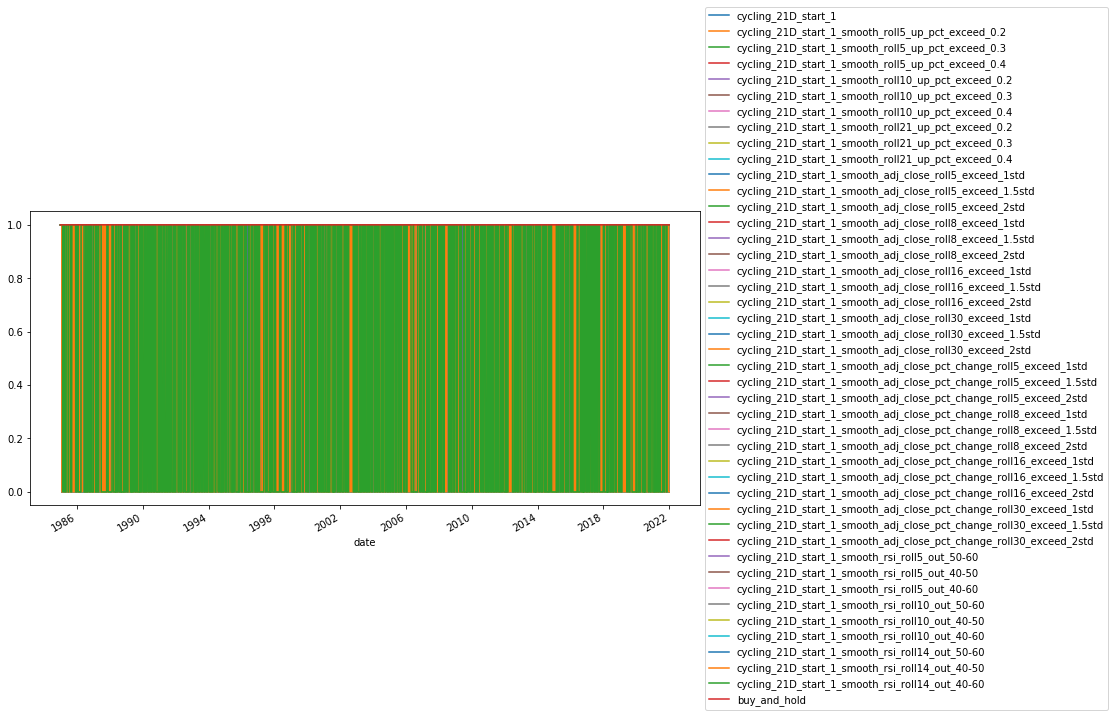

In [108]:
pred_all = pd.DataFrame()

for n,f in zip(name_list, file_list):
    p = pd.read_csv(f, index_col=0)
    if n in p.columns:
        p = p[n]
    else:
        p = p.y_pred
    p.index = pd.to_datetime(p.index)

    #display(p)
    
    pred_all[n] = p
    
    '''
    p_smooth = smooth_pred_by_flag(p, df.trade_flag_1)
    pred_all[n+'_smooth'] = p_smooth
    '''
    for s in flag.columns:
        p_smooth = smooth_pred_by_flag(p, flag[s])
        pred_all[n+'_smooth_'+s] = p_smooth
    
    
    
pred_all['buy_and_hold'] = 1

display(pred_all)
pred_all.plot(figsize=(12,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [49]:
#df.trade_flag_1

In [109]:
ret_all = pred_all.multiply(df.adj_close_pct_change.reindex(pred_all.index), 0)
ret_all

cycling_21D_start_1  \
date                              
1985-01-02            -0.009082   
1985-01-03            -0.010475   
1985-01-04             0.002646   
1985-01-07            -0.016166   
1985-01-08             0.012743   
...                         ...   
2021-12-27             0.000000   
2021-12-28            -0.000000   
2021-12-29            -0.000000   
2021-12-30             0.000000   
2021-12-31             0.000000   

            cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2  \
date                                                             
1985-01-02                                          -0.009082    
1985-01-03                                          -0.010475    
1985-01-04                                           0.002646    
1985-01-07                                          -0.016166    
1985-01-08                                           0.012743    
...                                                       ...    
2021-12-27                                           0.000000    
2021-12-28                                          -0.000000    
2021-12-29                                          -0.000000    
2021-12-30                                           0.000000    
2021-12-31                                           0.000000    

            cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3  \
date                                                             
1985-01-02                                          -0.009082    
1985-01-03                                          -0.010475    
1985-01-04                                           0.002646    
1985-01-07                                          -0.016166    
1985-01-08                                           0.012743    
...                                                       ...    
2021-12-27                                           0.000000    
2021-12-28                                          -0.000000    
2021-12-29                                          -0.000000    
2021-12-30                                           0.000000    
2021-12-31                                           0.000000    

            cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4  \
date                                                             
1985-01-02                                          -0.009082    
1985-01-03                                          -0.010475    
1985-01-04                                           0.002646    
1985-01-07                                          -0.016166    
1985-01-08                                           0.012743    
...                                                       ...    
2021-12-27                                           0.000000    
2021-12-28                                          -0.000000    
2021-12-29                                          -0.000000    
2021-12-30                                           0.000000    
2021-12-31                                           0.000000    

            cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.2  \
date                                                              
1985-01-02                                          -0.009082     
1985-01-03                                          -0.010475     
1985-01-04                                           0.002646     
1985-01-07                                          -0.016166     
1985-01-08                                           0.012743     
...                                                       ...     
2021-12-27                                           0.000000     
2021-12-28                                          -0.000000     
2021-12-29                                          -0.000000     
2021-12-30                                           0.000000     
2021-12-31                                           0.000000     

            cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.3  \
date                                    

In [58]:
#(1+ret_all).cumprod().plot()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.986371   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.986371   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.483042   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.495734   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.491781   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.491781   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.491781   
cycling_21D_start_1                                        0.492821   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.492821   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.492821   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.492821   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.494590   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.496463   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.491365   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.491365   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.491365   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.512380   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.496151   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.499688   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491989   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.493134   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.491781   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.495630   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.487828   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.540886   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.490221   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.517374   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.484082   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.482522   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.503849   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.493446   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.503641   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.506138   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.492613   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.486787   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.487412   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.495630   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491573   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.492301   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.026220  0.503329   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.026220  0.503329   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.050879  0.492093   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.059515  0.490012   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.060243  0.492301   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.060243  0.492301   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.060243  0.492301   
cycling_21D_start_1                                   0.060452  0.493342   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2    0.060452  0.493342   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.060452  0.493342   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.060452  0.493342   
cycling_21D_start_1_smooth_adj_close_roll8_exce...    0.061492  0.492821   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.061700  0.493862   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3    0.060452  0.493550   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.060452  0.49355

annual_return  \
buy_and_hold                                             0.047776   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.047776   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.047776   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.038572   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.039965   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4       0.040244   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.040244   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.040244   
cycling_21D_start_1                                      0.040500   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2       0.040500   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.040500   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.040500   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.040574   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.040170   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3       0.040523   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.040523   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.040523   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.041554   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60           0.042191   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60          0.042423   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.041900   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.042542   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50           0.043116   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.043143   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.044576   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.046877   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.044836   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.046011   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60          0.044663   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.045465   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.045883   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.045998   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.047424   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.048064   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.046878   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60          0.047311   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.048224   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60           0.048863   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.048249   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.049189   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.378081   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.378081   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.411003   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.412530   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      0.417328   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.417328   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.417328   
cycling_21D_start_1                                     0.420275   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      0.420275   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.420275   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.420275   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      0.420404   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.420447   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      0.420713   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.420713   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.420713  

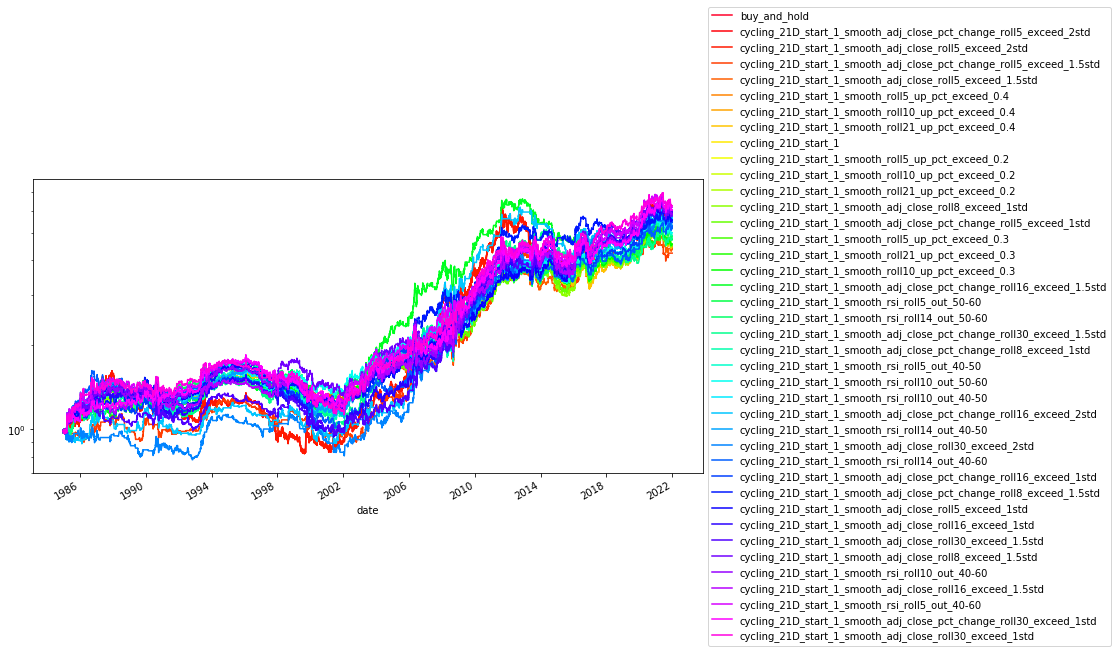

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.977508   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.977508   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.454572   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.488014   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.470257   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.470257   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.470257   
cycling_21D_start_1                                        0.488310   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.488310   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.488310   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.488310   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.483575   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.506363   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.484167   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.484167   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.484167   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.476768   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.490678   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.498668   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.472033   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.502220   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.484463   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.493341   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.476176   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.512578   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.482687   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.535365   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.449245   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.504587   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.494821   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.483575   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.485055   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.487126   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.493637   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.453389   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.459307   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.486534   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.504291   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.471737   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.043813  0.465226   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.043813  0.465226   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.062759  0.484463   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.069864  0.487126   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.070752  0.487718   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.070752  0.487718   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.070752  0.487718   
cycling_21D_start_1                                   0.070752  0.488014   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2    0.070752  0.488014   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.070752  0.488014   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.070752  0.488014   
cycling_21D_start_1_smooth_adj_close_roll8_exce...    0.073712  0.488606   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.072528  0.488310   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3    0.070752  0.489198   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.070752  0.48919

annual_return  \
buy_and_hold                                            -0.042235   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.042235   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.042235   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.009585   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.002242   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      -0.009399   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.009399   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.009399   
cycling_21D_start_1                                     -0.008555   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      -0.008555   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.008555   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.008555   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      -0.001764   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.007578   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      -0.006897   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.006897   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.006897   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.008609   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60          -0.009486   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60         -0.001841   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.006265   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.009573   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50          -0.011115   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.000842   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50         -0.013725   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.007509   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50         -0.016095   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.003144   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         -0.021215   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.005529   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.002401   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.006363   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      -0.020333   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.006392   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.002639   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60         -0.008053   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.004277   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60          -0.009831   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.005267   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.013330   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.283945   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.283945   
cycling_21D_start_1_smooth_adj_close_roll5_exce...     -0.283945   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.077556   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.017023   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4     -0.070761   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.070761   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.070761   
cycling_21D_start_1                                    -0.057282   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2     -0.057282   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.057282   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.057282   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      0.021512   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.044494   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3     -0.038293   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.038293   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.038293  

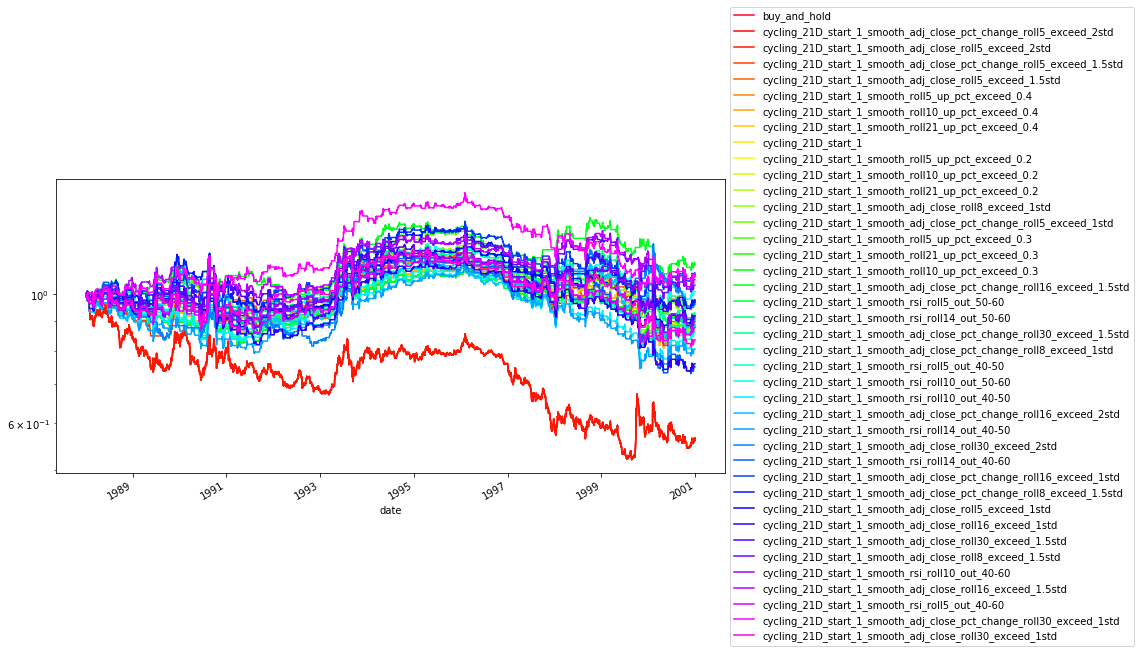

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.990223   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.990223   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.496858   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.486732   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.495112   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.495112   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.495112   
cycling_21D_start_1                                        0.493715   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.493715   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.498254   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.498953   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.493715   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.527584   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.500349   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.496159   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.489176   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491969   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.493017   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.495461   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.493366   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.555866   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.493715   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.493017   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.514665   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.480796   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.511872   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.501397   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.504539   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.514665   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.490573   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.498953   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.504190   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.495461   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.464036   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.504190   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.018861  0.533869   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.018861  0.533869   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.044010  0.506285   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.055187  0.494064   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.055187  0.503142   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.055187  0.503142   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.055187  0.503142   
cycling_21D_start_1                                   0.055187  0.504539   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2    0.055187  0.504539   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.055187  0.504539   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.055187  0.504539   
cycling_21D_start_1_smooth_adj_close_roll8_exce...    0.055187  0.502793   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.055885  0.505587   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3    0.055187  0.504539   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.055187  0.50453

annual_return  \
buy_and_hold                                             0.166255   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.166255   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.166255   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.130319   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.084970   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4       0.102328   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.102328   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.102328   
cycling_21D_start_1                                      0.096283   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2       0.096283   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.094919   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.094249   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3       0.096283   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.149269   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60           0.100781   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60          0.083455   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.128489   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.103417   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50           0.096248   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.087510   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.100931   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.166599   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.097057   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.139534   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60          0.110488   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.105447   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.125087   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.089719   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.119487   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.124401   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.092997   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60          0.107476   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.104677   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60           0.104975   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.101021   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.113313   

                                                    sharpe_ratio  \
buy_and_hold                                            0.914087   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.914087   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.914087   
cycling_21D_start_1_smooth_adj_close_pct_change...      1.027467   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.682812   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      0.803825   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.803825   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.803825   
cycling_21D_start_1                                     0.765437   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      0.765437   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.765437   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.765437   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      0.755612   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.758668   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      0.765437   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.765437   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.765437  

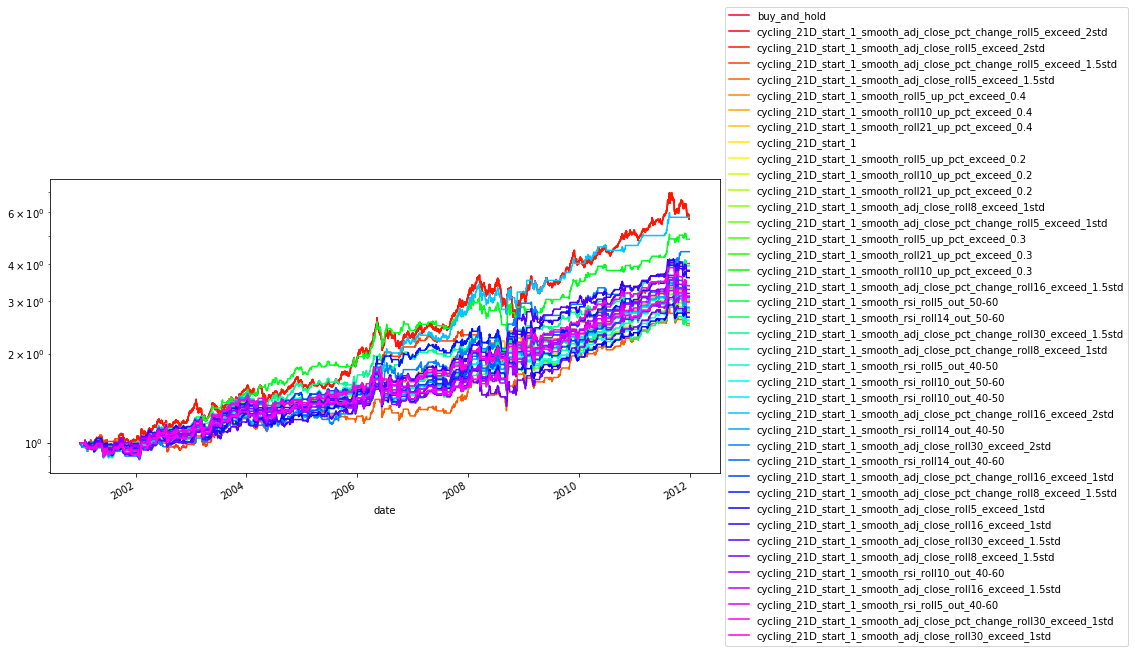

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.999040   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.999040   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.476008   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.501919   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.534549   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.534549   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.534549   
cycling_21D_start_1                                        0.503839   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.503839   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.503839   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.503839   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.525912   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.496161   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.498081   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.498081   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.498081   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.529750   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.509597   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.494242   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.471209   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.518234   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.503839   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.496161   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.512476   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.389635   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.509597   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.458733   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.497121   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.488484   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.473129   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.500960   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.531670   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.477927   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.518234   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.523033   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.508637   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.520154   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.527831   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.482726   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.001921  0.483685   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.001921  0.483685   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.041306  0.500000   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.047070  0.504798   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.046110  0.489443   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.046110  0.489443   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.046110  0.489443   
cycling_21D_start_1                                   0.048031  0.497121   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2    0.048031  0.497121   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.048031  0.497121   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.048031  0.497121   
cycling_21D_start_1_smooth_adj_close_roll8_exce...    0.049952  0.496161   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.049952  0.506718   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3    0.048031  0.495202   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.048031  0.49520

annual_return  \
buy_and_hold                                            -0.089555   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.089555   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.089555   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.041301   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.010211   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      -0.028624   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.028624   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.028624   
cycling_21D_start_1                                     -0.009276   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      -0.009276   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.009276   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.009276   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      -0.025896   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.005999   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      -0.010517   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.010517   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.010517   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.072077   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60          -0.013453   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60         -0.006349   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.028332   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.000788   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50          -0.003397   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60         -0.008431   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.007169   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.071577   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.025239   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.016778   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         -0.012934   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.014966   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.013287   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.017799   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.007797   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.008622   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      -0.003017   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60         -0.014923   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      -0.020206   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60          -0.005974   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.000124   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.007142   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.494734   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.494734   
cycling_21D_start_1_smooth_adj_close_roll5_exce...     -0.494734   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.353817   
cycling_21D_start_1_smooth_adj_close_roll5_exce...     -0.039645   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4     -0.201763   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.201763   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.201763   
cycling_21D_start_1                                    -0.031575   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2     -0.031575   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.031575   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.031575   
cycling_21D_start_1_smooth_adj_close_roll8_exce...     -0.181988   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.109369   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3     -0.043621   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.043621   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.043621  

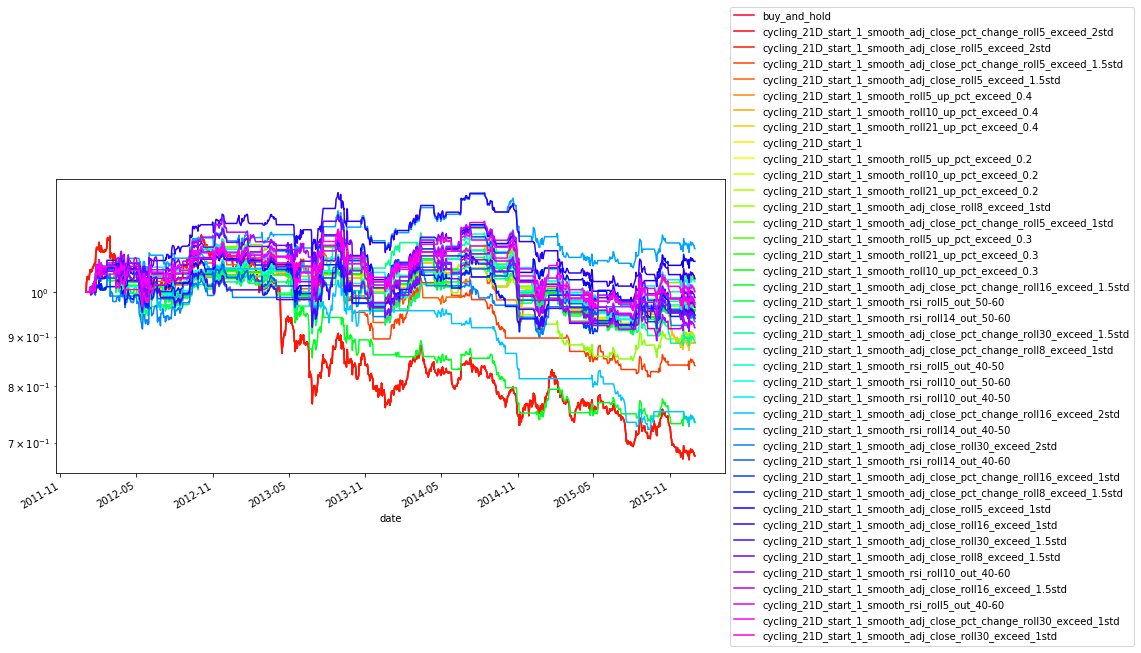

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         1.000000   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         1.000000   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.507997   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.538708   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.506718   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.506718   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.506718   
cycling_21D_start_1                                        0.497121   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.497121   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.497121   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.497121   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.507997   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491363   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.500960   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.500960   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.500960   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.527831   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.496481   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.511836   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.512476   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.488804   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.497121   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.503519   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.487524   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.657710   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.493922   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.552783   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.477927   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.462572   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.532310   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.504798   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.514395   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.505438   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.500320   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.495841   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.489443   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.495841   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.508637   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.513756   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.000000  0.536148   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.000000  0.536148   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.037772  0.494562   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.046095  0.489443   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.047375  0.484325   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.047375  0.484325   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.047375  0.484325   
cycling_21D_start_1                                   0.047375  0.482406   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2    0.047375  0.482406   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.047375  0.482406   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.047375  0.482406   
cycling_21D_start_1_smooth_adj_close_roll8_exce...    0.047375  0.490723   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.047375  0.480486   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3    0.047375  0.482406   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.047375  0.48240

annual_return  \
buy_and_hold                                             0.091659   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.091659   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.091659   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.044851   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.053357   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4       0.051477   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.051477   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.051477   
cycling_21D_start_1                                      0.047910   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2       0.047910   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.047910   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.047910   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.062279   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.047030   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3       0.045145   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.045145   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.045145   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.003984   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60           0.055812   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60          0.056451   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.030330   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.051184   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50           0.059835   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.054891   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.058630   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.054525   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.058067   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.064461   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60          0.075242   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.063855   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.031201   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.068279   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.073321   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.080504   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.061887   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60          0.073414   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.087600   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60           0.071208   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.070469   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.071739   

                                                    sharpe_ratio  \
buy_and_hold                                            0.718013   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.718013   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.718013   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.482870   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.565561   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      0.567801   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.567801   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.567801   
cycling_21D_start_1                                     0.535342   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      0.535342   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.535342   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.535342   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      0.670567   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.532511   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      0.506348   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.506348   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.506348  

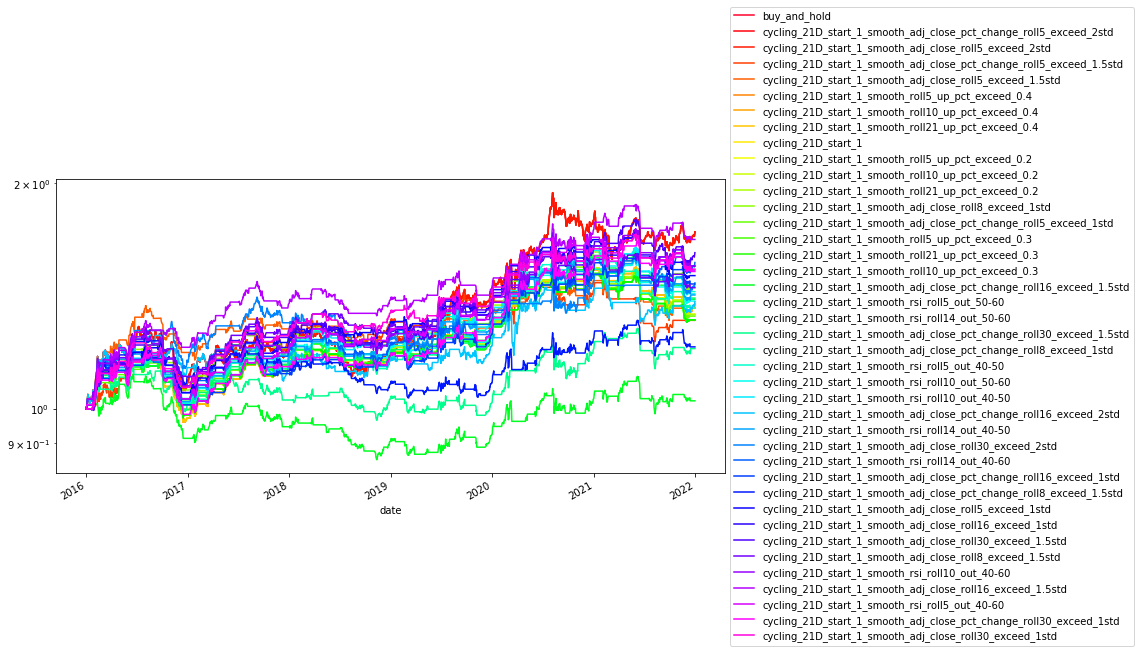

['buy_and_hold',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll5_exceed_2std',
 'cycling_21D_start_1_smooth_adj_close_roll5_exceed_2std',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll5_exceed_1.5std',
 'cycling_21D_start_1_smooth_adj_close_roll5_exceed_1.5std',
 'cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4',
 'cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.4',
 'cycling_21D_start_1_smooth_roll21_up_pct_exceed_0.4',
 'cycling_21D_start_1',
 'cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2',
 'cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.2',
 'cycling_21D_start_1_smooth_roll21_up_pct_exceed_0.2',
 'cycling_21D_start_1_smooth_adj_close_roll8_exceed_1std',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll5_exceed_1std',
 'cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3',
 'cycling_21D_start_1_smooth_roll21_up_pct_exceed_0.3',
 'cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.3',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll16_exceed_1.5

In [110]:
strategy_list_sel = print_all_result(ret_all, sortby='sharpe_ratio', topn='buy_and_hold')

print_all_result(ret_all['1988':'2000'], sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)
print_all_result(ret_all['2001':'2011'], sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)
print_all_result(ret_all['2012':'2015'], sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)
print_all_result(ret_all['2016':'2021'], sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.986371   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.986371   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.485019   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.503329   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.512380   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.483042   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.484082   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.540886   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.491781   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.491781   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.491781   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491989   
cycling_21D_start_1                                        0.492821   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.492821   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.492821   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.492821   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.495734   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.491365   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.491365   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.491365   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.496463   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.490221   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.496151   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.503849   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.494590   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.503641   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.487828   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.506138   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.491781   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.493134   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.517374   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.486787   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.499688   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.493446   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.495630   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.482522   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491573   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.495630   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.492301   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.492613   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.487412   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.026220  0.503329   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.026220  0.503329   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.036000  0.489076   
cycling_21D_start_1_smooth_adj_close_roll16_exc...    0.050255  0.488452   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.059203  0.492717   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.050879  0.492093   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60       0.055978  0.493758   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.037873  0.494798   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.060243  0.492301   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.060243  0.492301   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.060243  0.492301   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.055665  0.491469   
cycling_21D_start_1                                   0.060452  0.493342   
cycli

annual_return  \
buy_and_hold                                             0.047776   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.047776   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.047776   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.028255   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.034694   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.041554   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.038572   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60          0.044663   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.046877   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4       0.040244   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.040244   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.040244   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.041900   
cycling_21D_start_1                                      0.040500   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2       0.040500   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.040500   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.040500   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.039965   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.040523   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3       0.040523   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.040523   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.040170   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.044836   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60           0.042191   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.045883   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.040574   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.047424   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.044576   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.048064   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50           0.043116   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.042542   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.046011   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60          0.047311   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60          0.042423   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.045998   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.043143   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.045465   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.048249   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60           0.048863   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.049189   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.046878   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.048224   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.378081   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.378081   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.312192   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      0.360359   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.423668   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.411003   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         0.462033   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.456699   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      0.417328   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.417328   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.417328   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.438369   
cycling_21D_start_1                                     0.420275   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      0.420275

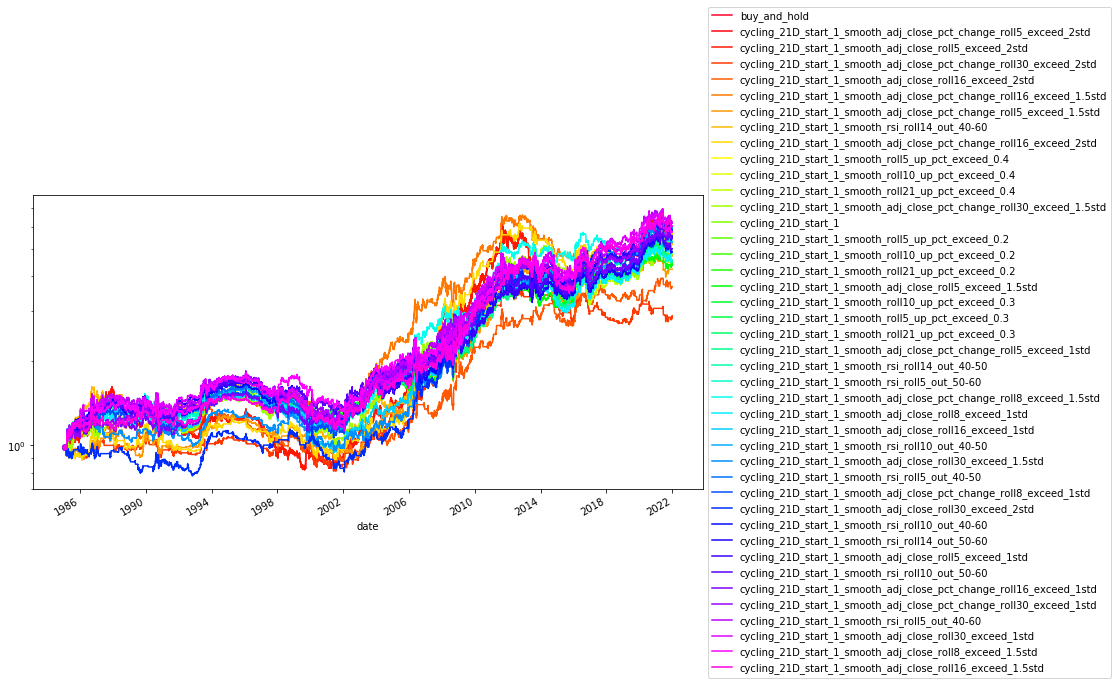

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.977508   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.977508   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.472329   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.513761   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.476768   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.454572   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.449245   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.512578   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.470257   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.470257   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.470257   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.472033   
cycling_21D_start_1                                        0.488310   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.488310   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.488310   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.488310   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.488014   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.484167   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.484167   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.484167   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.506363   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.482687   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.490678   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.494821   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.483575   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.485055   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.476176   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.487126   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.484463   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.502220   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.535365   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.453389   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.498668   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.483575   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.493341   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.504587   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.504291   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.486534   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.471737   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.493637   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.459307   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.043813  0.465226   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.043813  0.465226   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.044109  0.498668   
cycling_21D_start_1_smooth_adj_close_roll16_exc...    0.059503  0.488606   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.069864  0.493637   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.062759  0.484463   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60       0.063943  0.483279   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.046477  0.495117   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.070752  0.487718   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.070752  0.487718   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.070752  0.487718   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.064535  0.492453   
cycling_21D_start_1                                   0.070752  0.488014   
cycli

annual_return  \
buy_and_hold                                            -0.042235   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.042235   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.042235   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.008404   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      -0.012907   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.008609   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.009585   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         -0.021215   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.007509   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      -0.009399   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.009399   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.009399   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.006265   
cycling_21D_start_1                                     -0.008555   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      -0.008555   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.008555   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.008555   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.002242   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.006897   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      -0.006897   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.006897   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.007578   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50         -0.016095   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60          -0.009486   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.002401   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      -0.001764   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      -0.020333   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50         -0.013725   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.006392   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50          -0.011115   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.009573   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.003144   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60         -0.008053   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60         -0.001841   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.006363   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.000842   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.005529   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.005267   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60          -0.009831   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.013330   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.002639   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.004277   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.283945   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.283945   
cycling_21D_start_1_smooth_adj_close_roll5_exce...     -0.283945   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.063348   
cycling_21D_start_1_smooth_adj_close_roll16_exc...     -0.104741   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.146987   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.077556   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60        -0.230345   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.044837   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4     -0.070761   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.070761   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.070761   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.040385   
cycling_21D_start_1                                    -0.057282   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2     -0.057282

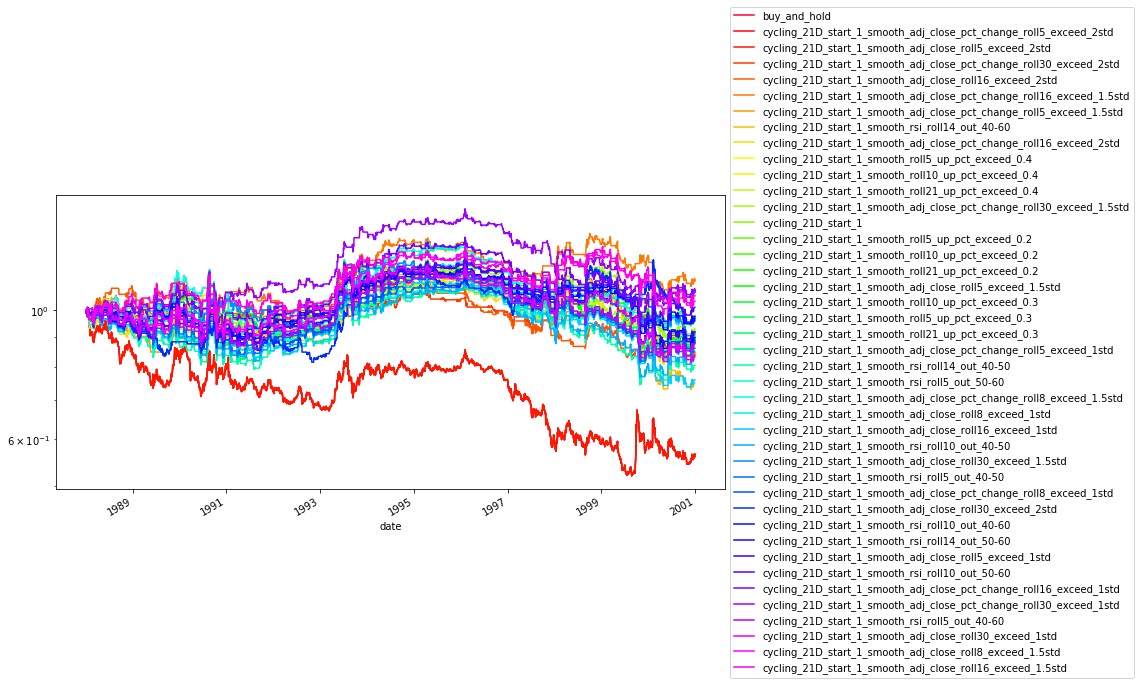

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.990223   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.990223   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.519553   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.536313   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.527584   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.496858   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.514665   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.555866   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.495112   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.495112   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.495112   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.489176   
cycling_21D_start_1                                        0.493715   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.493715   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.486732   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.493715   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.493715   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.498953   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.493715   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.500349   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.511872   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.498254   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.504539   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.493366   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.514665   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.493017   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491969   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.493017   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.498953   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.496159   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.501397   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.495461   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.480796   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.464036   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.495461   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.504190   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.490573   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.504190   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.018861  0.533869   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.018861  0.533869   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.033182  0.496858   
cycling_21D_start_1_smooth_adj_close_roll16_exc...    0.045756  0.488478   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.053790  0.509078   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.044010  0.506285   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60       0.053790  0.500349   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.031086  0.501746   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.055187  0.503142   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.055187  0.503142   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.055187  0.503142   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.051694  0.499302   
cycling_21D_start_1                                   0.055187  0.504539   
cycli

annual_return  \
buy_and_hold                                             0.166255   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.166255   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.166255   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.126878   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.093333   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.149269   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.130319   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60          0.110488   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.166599   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4       0.102328   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.102328   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.102328   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.128489   
cycling_21D_start_1                                      0.096283   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2       0.096283   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.084970   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3       0.096283   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.096283   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.094249   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.097057   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60           0.100781   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.125087   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.094919   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.119487   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.100931   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.124401   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50           0.096248   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.103417   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.139534   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60          0.107476   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60          0.083455   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.089719   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.087510   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.105447   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.101021   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60           0.104975   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.113313   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.092997   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.104677   

                                                    sharpe_ratio  \
buy_and_hold                                            0.914087   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.914087   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.914087   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.959599   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      0.692915   
cycling_21D_start_1_smooth_adj_close_pct_change...      1.072813   
cycling_21D_start_1_smooth_adj_close_pct_change...      1.027467   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         0.845757   
cycling_21D_start_1_smooth_adj_close_pct_change...      1.161233   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      0.803825   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.803825   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.803825   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.979681   
cycling_21D_start_1                                     0.765437   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      0.765437

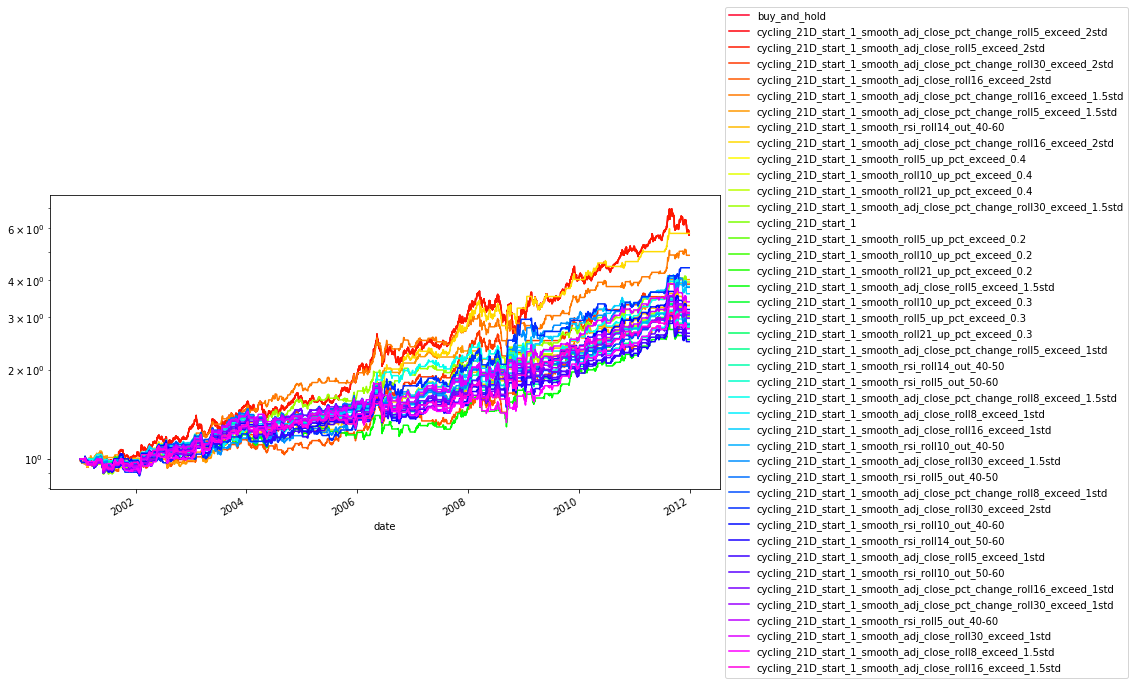

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         0.999040   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.999040   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.367562   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.410749   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.529750   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.476008   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.497121   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.389635   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.534549   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.534549   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.534549   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.471209   
cycling_21D_start_1                                        0.503839   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.503839   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.503839   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.503839   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.501919   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.498081   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.498081   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.498081   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.496161   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.509597   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.509597   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.473129   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.525912   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.531670   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.512476   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.477927   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.503839   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.518234   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.458733   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.523033   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.494242   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.500960   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.496161   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.488484   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.527831   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.520154   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.482726   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.518234   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.508637   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.001921  0.483685   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.001921  0.483685   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.020173  0.483685   
cycling_21D_start_1_smooth_adj_close_roll16_exc...    0.039385  0.511516   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.048991  0.482726   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.041306  0.500000   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60       0.045149  0.509597   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.025937  0.494242   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.046110  0.489443   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.046110  0.489443   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.046110  0.489443   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.043228  0.495202   
cycling_21D_start_1                                   0.048031  0.497121   
cycli

annual_return  \
buy_and_hold                                            -0.089555   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.089555   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.089555   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.053146   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.001970   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.072077   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.041301   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         -0.012934   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.071577   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      -0.028624   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.028624   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.028624   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.028332   
cycling_21D_start_1                                     -0.009276   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      -0.009276   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.009276   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.009276   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      -0.010211   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      -0.010517   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3      -0.010517   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      -0.010517   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.005999   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.025239   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60          -0.013453   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.013287   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      -0.025896   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.007797   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.007169   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.008622   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50          -0.003397   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.000788   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.016778   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60         -0.014923   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60         -0.006349   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.017799   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60         -0.008431   
cycling_21D_start_1_smooth_adj_close_pct_change...      -0.014966   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.000124   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60          -0.005974   
cycling_21D_start_1_smooth_adj_close_roll30_exc...      -0.007142   
cycling_21D_start_1_smooth_adj_close_roll8_exce...      -0.003017   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      -0.020206   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.494734   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.494734   
cycling_21D_start_1_smooth_adj_close_roll5_exce...     -0.494734   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.500880   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      0.068866   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.608932   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.353817   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60        -0.072321   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.678870   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4     -0.201763   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...     -0.201763   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...     -0.201763   
cycling_21D_start_1_smooth_adj_close_pct_change...     -0.227806   
cycling_21D_start_1                                    -0.031575   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2     -0.031575

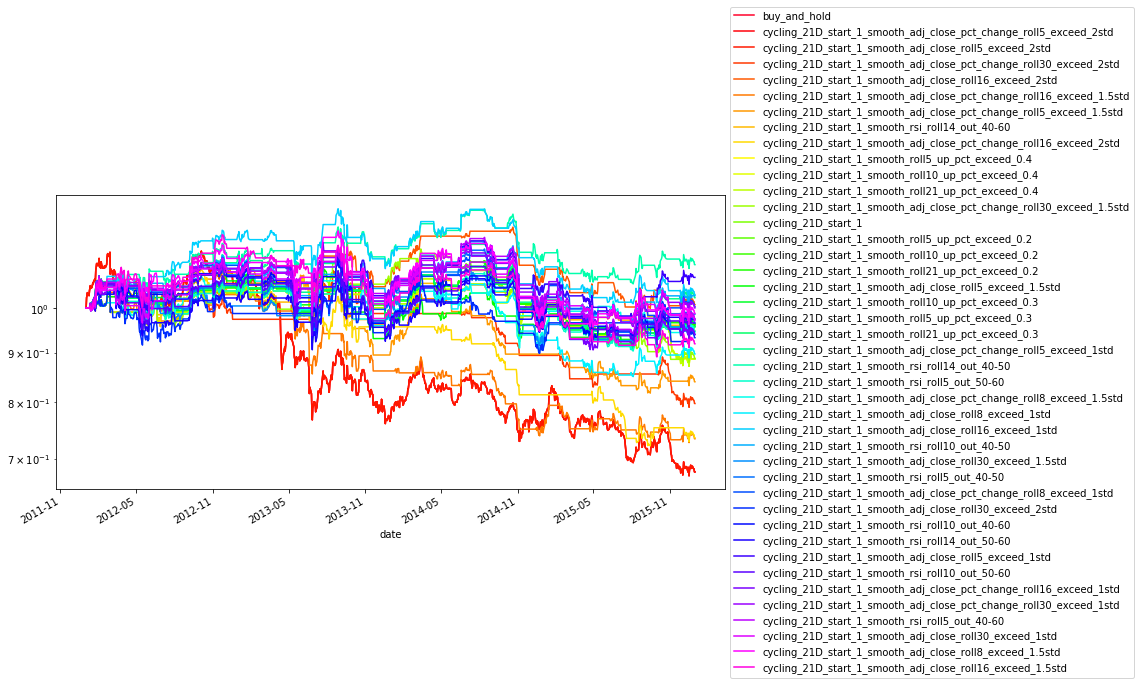

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
cycling_21D_start_1_smooth_adj_close_pct_change...         1.000000   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         1.000000   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.490083   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.465771   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.527831   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.507997   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60            0.477927   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.657710   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4         0.506718   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.506718   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.506718   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.512476   
cycling_21D_start_1                                        0.497121   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2         0.497121   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.497121   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.497121   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.538708   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...         0.500960   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3         0.500960   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...         0.500960   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.491363   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50            0.493922   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60             0.496481   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.532310   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.507997   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.514395   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50            0.487524   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.505438   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50             0.497121   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.488804   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.552783   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60            0.495841   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60            0.511836   
cycling_21D_start_1_smooth_adj_close_roll5_exce...         0.504798   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60            0.503519   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.462572   
cycling_21D_start_1_smooth_adj_close_pct_change...         0.508637   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60             0.495841   
cycling_21D_start_1_smooth_adj_close_roll30_exc...         0.513756   
cycling_21D_start_1_smooth_adj_close_roll8_exce...         0.500320   
cycling_21D_start_1_smooth_adj_close_roll16_exc...         0.489443   

                                                    flip_ratio      accu  \
cycling_21D_start_1_smooth_adj_close_pct_change...    0.000000  0.536148   
cycling_21D_start_1_smooth_adj_close_roll5_exce...    0.000000  0.536148   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.024328  0.477927   
cycling_21D_start_1_smooth_adj_close_roll16_exc...    0.036492  0.492003   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.046735  0.484965   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.037772  0.494562   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60       0.042254  0.501599   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.026889  0.508637   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4    0.047375  0.484325   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...    0.047375  0.484325   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...    0.047375  0.484325   
cycling_21D_start_1_smooth_adj_close_pct_change...    0.042894  0.486244   
cycling_21D_start_1                                   0.047375  0.482406   
cycli

annual_return  \
buy_and_hold                                             0.091659   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.091659   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.091659   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.007141   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.051811   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.003984   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.044851   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60          0.075242   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.054525   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4       0.051477   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.051477   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.051477   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.030330   
cycling_21D_start_1                                      0.047910   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2       0.047910   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.047910   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.047910   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.053357   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...       0.045145   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.3       0.045145   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...       0.045145   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.047030   
cycling_21D_start_1_smooth_rsi_roll14_out_40-50          0.058067   
cycling_21D_start_1_smooth_rsi_roll5_out_50-60           0.055812   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.031201   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.062279   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.073321   
cycling_21D_start_1_smooth_rsi_roll10_out_40-50          0.058630   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.080504   
cycling_21D_start_1_smooth_rsi_roll5_out_40-50           0.059835   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.051184   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.064461   
cycling_21D_start_1_smooth_rsi_roll10_out_40-60          0.073414   
cycling_21D_start_1_smooth_rsi_roll14_out_50-60          0.056451   
cycling_21D_start_1_smooth_adj_close_roll5_exce...       0.068279   
cycling_21D_start_1_smooth_rsi_roll10_out_50-60          0.054891   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.063855   
cycling_21D_start_1_smooth_adj_close_pct_change...       0.070469   
cycling_21D_start_1_smooth_rsi_roll5_out_40-60           0.071208   
cycling_21D_start_1_smooth_adj_close_roll30_exc...       0.071739   
cycling_21D_start_1_smooth_adj_close_roll8_exce...       0.061887   
cycling_21D_start_1_smooth_adj_close_roll16_exc...       0.087600   

                                                    sharpe_ratio  \
buy_and_hold                                            0.718013   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.718013   
cycling_21D_start_1_smooth_adj_close_roll5_exce...      0.718013   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.121281   
cycling_21D_start_1_smooth_adj_close_roll16_exc...      0.609687   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.089624   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.482870   
cycling_21D_start_1_smooth_rsi_roll14_out_40-60         0.839133   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.527073   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4      0.567801   
cycling_21D_start_1_smooth_roll10_up_pct_exceed...      0.567801   
cycling_21D_start_1_smooth_roll21_up_pct_exceed...      0.567801   
cycling_21D_start_1_smooth_adj_close_pct_change...      0.368300   
cycling_21D_start_1                                     0.535342   
cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2      0.535342

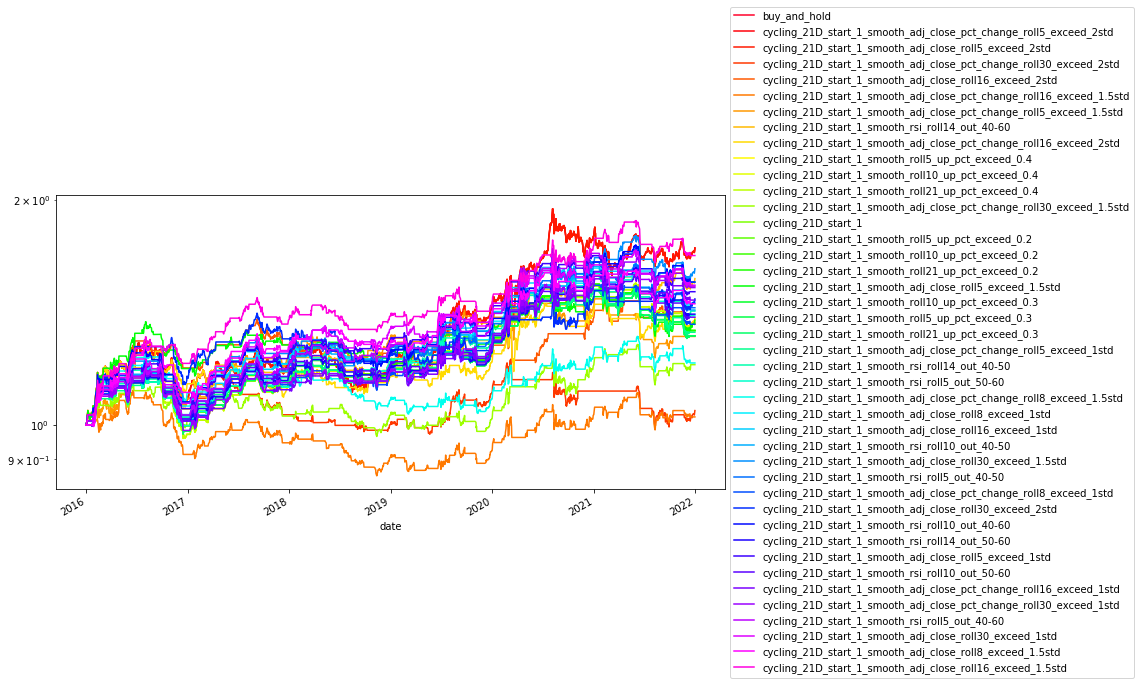

['buy_and_hold',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll5_exceed_2std',
 'cycling_21D_start_1_smooth_adj_close_roll5_exceed_2std',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll30_exceed_2std',
 'cycling_21D_start_1_smooth_adj_close_roll16_exceed_2std',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll16_exceed_1.5std',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll5_exceed_1.5std',
 'cycling_21D_start_1_smooth_rsi_roll14_out_40-60',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll16_exceed_2std',
 'cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.4',
 'cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.4',
 'cycling_21D_start_1_smooth_roll21_up_pct_exceed_0.4',
 'cycling_21D_start_1_smooth_adj_close_pct_change_roll30_exceed_1.5std',
 'cycling_21D_start_1',
 'cycling_21D_start_1_smooth_roll5_up_pct_exceed_0.2',
 'cycling_21D_start_1_smooth_roll10_up_pct_exceed_0.2',
 'cycling_21D_start_1_smooth_roll21_up_pct_exceed_0.2',
 'cycling_21D_start_1_sm

In [111]:
strategy_list_sel = print_all_result(ret_all, sortby='return/avgdd', topn='buy_and_hold')

print_all_result(ret_all['1988':'2000'], sortby='return/avgdd', strategy_list_sel=strategy_list_sel)
print_all_result(ret_all['2001':'2011'], sortby='return/avgdd', strategy_list_sel=strategy_list_sel)
print_all_result(ret_all['2012':'2015'], sortby='return/avgdd', strategy_list_sel=strategy_list_sel)
print_all_result(ret_all['2016':'2021'], sortby='return/avgdd', strategy_list_sel=strategy_list_sel)

In [27]:
"""list_tmp = [
    'no_pred', 
    'pred_vote_crossema_6xgb', 
    'pred_vote_crossema_6xgb_smooth_adj_close_pct_change_roll8_exceed_1.5std',
]


fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all[list_tmp].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

(1+ret_all[list_tmp]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")"""

'list_tmp = [\n    \'no_pred\', \n    \'pred_vote_crossema_6xgb\', \n    \'pred_vote_crossema_6xgb_smooth_adj_close_pct_change_roll8_exceed_1.5std\',\n]\n\n\nfig, ax = plt.subplots(figsize=(12,6))\n\ncm = plt.get_cmap(\'gist_rainbow\')\nNUM_COLORS = ret_all[list_tmp].shape[1]\nax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])\n\n(1+ret_all[list_tmp]).cumprod().plot(ax=ax)\nax.legend(loc=\'center left\', bbox_to_anchor=(1, 0.5))\nax.set_yscale("log")'